In [16]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt

In [17]:
root_dir = "datasets"
tfrecords_dir = "tfrecords"
train_images_dir = os.path.join(root_dir, "train2017")
val_images_dir = os.path.join(root_dir, "val2017")
train_annotation_file = os.path.join(root_dir, "lvis_v1_train.json")
val_annotation_file = os.path.join(root_dir, "lvis_v1_val.json")
train_images_url = "http://images.cocodataset.org/zips/train2017.zip"
val_images_url = "http://images.cocodataset.org/zips/val2017.zip"
train_annotations_url = (
    "https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip"
)
val_annotations_url = (
    "https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip"
)

In [18]:
# Download image files
if not os.path.exists(train_images_dir):
    image_zip = tf.keras.utils.get_file(
        "images.zip", cache_dir=os.path.abspath("."), origin=train_images_url, extract=True,
    )
    os.remove(image_zip)
if not os.path.exists(val_images_dir):
    image_zip = tf.keras.utils.get_file(
        "images.zip", cache_dir=os.path.abspath("."), origin=val_images_url, extract=True,
    )
    os.remove(image_zip)

815585330/815585330 [==============================] - 50s 0us/step


In [19]:
# Download caption annotation files
if not os.path.exists(train_annotation_file):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=train_annotations_url,
        extract=True,
    )
    os.remove(annotation_zip)
    
if not os.path.exists(val_annotation_file):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=val_annotations_url,
        extract=True,
    )
    os.remove(annotation_zip)

print("The LVIS dataset has been downloaded and extracted successfully.")

64026968/64026968 [==============================] - 4s 0us/step
The LVIS dataset has been downloaded and extracted successfully.


In [20]:
with open(train_annotation_file, "r") as f:
    train_annotations = json.load(f)["annotations"]
    
with open(val_annotation_file, "r") as f:
    val_annotations = json.load(f)["annotations"] 

print(f"Number of train images: {len(train_annotations)}")
print(f"Number of validation images: {len(val_annotations)}")

Number of train images: 1270141
Number of validation images: 244707


In [21]:
pprint.pprint(train_annotations[60])

{'area': 15.25,
 'bbox': [235.4, 291.18, 22.18, 1.65],
 'category_id': 1037,
 'id': 61,
 'image_id': 402711,
 'segmentation': [[236.27,
                   291.27,
                   235.4,
                   291.73,
                   244.38,
                   292.65,
                   245.66,
                   292.28,
                   245.48,
                   291.54,
                   239.06,
                   291.18,
                   237.23,
                   291.18,
                   236.27,
                   291.27],
                  [251.35,
                   291.91,
                   251.71,
                   292.83,
                   257.03,
                   292.65,
                   257.58,
                   291.91,
                   256.48,
                   291.54,
                   255.38,
                   291.54,
                   251.35,
                   291.91]]}


In [22]:
train_num_samples = 1270141
val_num_samples = 244707

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

In [23]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

In [24]:
# since LVIS val instance includes train data, create val first
samples = val_annotations[:]

with tf.io.TFRecordWriter(tfrecords_dir + "/LVIS_val.tfrecord") as writer:
    for sample in samples:
        image_path = f"{train_images_dir}/{sample['image_id']:012d}.jpg"
        if not os.path.exists(image_path):
            image_path = f"{val_images_dir}/{sample['image_id']:012d}.jpg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())

In [27]:
# no need val image data anymore
import shutil

if os.path.exists(train_images_dir):
    shutil.rmtree(train_images_dir)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [26]:
# Create train tfrecord file
samples = train_annotations[:]

with tf.io.TFRecordWriter(tfrecords_dir + "/LVIS_train.tfrecord") as writer:
    for sample in samples:
        image_path = f"{train_images_dir}/{sample['image_id']:012d}.jpg"
        image = tf.io.decode_jpeg(tf.io.read_file(image_path))
        example = create_example(image, image_path, sample)
        writer.write(example.SerializeToString())

ResourceExhaustedError: tfrecords/LVIS_train.tfrecord; No space left on device

bbox: [ 83.08 219.88 301.69 420.12]
area: 73297.4765625
category_id: 232
id: 1
image_id: 446522
path: b'datasets/val2017/000000446522.jpg'
Image shape: (640, 480, 3)


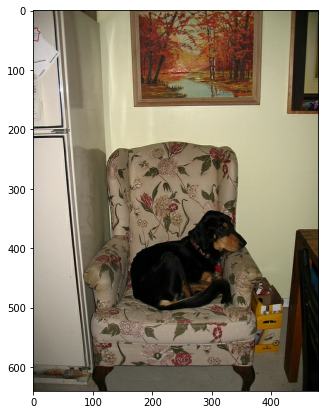

In [15]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/LVIS_val.tfrecord")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()